### Imports

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms
from transformers import AutoImageProcessor, Swinv2ForImageClassification
from sklearn.metrics import accuracy_score
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np


In [2]:
torch.cuda.is_available(), torch.cuda.get_device_name(0)

(True, 'NVIDIA GeForce RTX 3060')

### Hyperparameters

In [3]:
batch_size = 16
learning_rate = 1e-4
num_epochs = 75
save_interval = 5
num_classes = 4
dir = 'hp-swinv2-base'
import wandb

sweep_config = {
    'method': 'grid', 
    'metric': {'name': 'val_loss', 'goal': 'minimize'},
    'parameters': {
        'batch_size': {'values': [16, 32, 64]},
        'learning_rate': {'values': [1e-5, 1e-4, 5e-4]}, 
        'num_epochs': {'value': num_epochs},  
        'num_classes': {'value': num_classes}, 
    }
}

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="swinv2-bc-hp-base-patch4-window8-v2")

### Data Preprocessing

In [62]:
image_processor = AutoImageProcessor.from_pretrained("microsoft/swinv2-base-patch4-window8-256")

transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomRotation(degrees=15),  # Rotate up to ±15 degrees
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),  # Small affine transformation
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),  # Apply random perspective distortion
    transforms.ToTensor(),
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
])

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
])

### Load Datasets


In [5]:
full_train_dataset = datasets.ImageFolder("dataset/train")

train_size = int(0.875 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_subset, val_subset = random_split(full_train_dataset, [train_size, val_size])

train_indices = train_subset.indices
val_indices = val_subset.indices


train_dataset_full = datasets.ImageFolder("dataset/train", transform=transform_train)
val_dataset_full = datasets.ImageFolder("dataset/train", transform=transform)

train_dataset = Subset(train_dataset_full, train_indices)
val_dataset = Subset(val_dataset_full, val_indices)

test_dataset = datasets.ImageFolder("dataset/test", transform=transform)

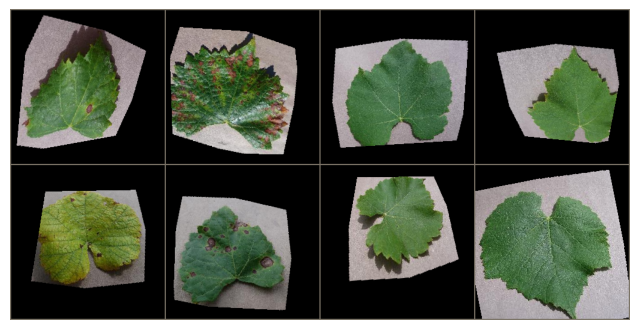

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

mean = np.array(image_processor.image_mean)
std = np.array(image_processor.image_std)

# Unnormalize and make a grid
grid = vutils.make_grid(images, nrow=4, padding=2)
grid = grid.cpu().numpy().transpose(1, 2, 0)
grid = std * grid + mean  # unnormalize
grid = np.clip(grid, 0, 1)

plt.figure(figsize=(8, 8))
plt.imshow(grid)
plt.axis('off')
plt.show()

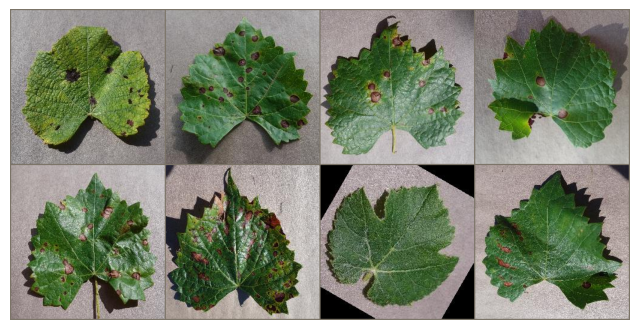

In [7]:
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)
dataiter = iter(val_dataloader)
images, labels = next(dataiter)

mean = np.array(image_processor.image_mean)
std = np.array(image_processor.image_std)

# Unnormalize and make a grid
grid = vutils.make_grid(images, nrow=4, padding=2)
grid = grid.cpu().numpy().transpose(1, 2, 0)
grid = std * grid + mean  # unnormalize
grid = np.clip(grid, 0, 1)

plt.figure(figsize=(8, 8))
plt.imshow(grid)
plt.axis('off')
plt.show()

### Training Function


In [8]:
def train(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    return avg_loss

### Validation Function


In [9]:
def validate(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    avg_loss = total_loss / len(val_loader)
    return avg_loss, accuracy

### Main Function


In [ ]:
import os

os.makedirs('hp-swinv2-base', exist_ok=True)
device = "cuda" if torch.cuda.is_available() else "cpu"
def train_with_sweep():
    # Initialize W&B
    wandb.init()

    # Get hyperparameters from W&B
    config = wandb.config

    # Set up model
    model = Swinv2ForImageClassification.from_pretrained(
        "microsoft/swinv2-base-patch4-window8-256", 
        num_labels=config.num_classes, 
        ignore_mismatched_sizes=True)
    model.to(device)    

    # Set up optimizer and criterion
    optimizer = optim.AdamW(
        model.parameters(), 
        lr=config.learning_rate
        )
    criterion = nn.CrossEntropyLoss()

    # Dynamically set batch size in DataLoader
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

    patience = 10  # Stop training if no improvement for 'patience' epochs
    min_delta = 1e-4  # Minimum change in val_loss to qualify as improvement
    best_val_loss = float('inf')
    patience_counter = 0

    # Training loop
    for epoch in range(config.num_epochs):
        train_loss = train(model, train_loader, criterion, optimizer)
        print(f"Epoch {epoch+1}/{config.num_epochs}")
        print(f"Train Loss: {train_loss:.4f}")

        # Validation
        val_loss, val_accuracy = validate(model, val_loader, criterion)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Log metrics to W&B
        wandb.log({
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_accuracy': val_accuracy,
            'epoch': epoch + 1
        })

        # Check early stopping criteria
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            patience_counter = 0  # Reset patience counter
            # Save the model if it's the best so far
            torch.save(model.state_dict(), f'hp-swinv2-base/model_lr{config.learning_rate}_bs{config.batch_size}.pth')
            print(f"New best model saved. Validation Loss: {val_loss:.4f}")
        else:
            patience_counter += 1
            print(f"No improvement in validation loss for {patience_counter} epoch(s).")

        # Early stopping condition
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    print("Evaluating the best model on the test dataset...")
    model.load_state_dict(torch.load(f'hp-swinv2-base/model_lr{config.learning_rate}_bs{config.batch_size}.pth'))
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = accuracy_score(all_labels, all_preds)
    print(f"Final Test Accuracy: {test_accuracy:.4f}")

    # Log final test accuracy to W&B
    wandb.log({'final_test_accuracy': test_accuracy})

wandb.agent(sweep_id, function=train_with_sweep)

wandb: Agent Starting Run: cnpm3cpo with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 1e-05
wandb: 	num_classes: 4
wandb: 	num_epochs: 75
wandb: Currently logged in as: adam-kacmar59 (adam-kacmar59-fiit-stu). Use `wandb login --relogin` to force relogin


Some weights of Swinv2ForImageClassification were not initialized from the model checkpoint at microsoft/swinv2-base-patch4-window8-256 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([4, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/75
Train Loss: 0.1586
Validation Loss: 0.0219, Validation Accuracy: 0.9945
New best model saved. Validation Loss: 0.0219
Epoch 2/75
Train Loss: 0.0096
Validation Loss: 0.0362, Validation Accuracy: 0.9889
No improvement in validation loss for 1 epoch(s).
Epoch 3/75
Train Loss: 0.0094
Validation Loss: 0.0162, Validation Accuracy: 0.9956
New best model saved. Validation Loss: 0.0162
Epoch 4/75
Train Loss: 0.0093
Validation Loss: 0.0004, Validation Accuracy: 1.0000
New best model saved. Validation Loss: 0.0004
Epoch 5/75
Train Loss: 0.0011
Validation Loss: 0.0003, Validation Accuracy: 1.0000
No improvement in validation loss for 1 epoch(s).
Epoch 6/75
Train Loss: 0.0045
Validation Loss: 0.0004, Validation Accuracy: 1.0000
No improvement in validation loss for 2 epoch(s).
Epoch 7/75
Train Loss: 0.0011
Validation Loss: 0.0001, Validation Accuracy: 1.0000
New best model saved. Validation Loss: 0.0001
Epoch 8/75
Train Loss: 0.0010
Validation Loss: 0.0000, Validation Accuracy: 1.0000
No

C:\Users\Admin\AppData\Local\Temp\ipykernel_10112\1831228848.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'hp-swinv2-base/model_epo

epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▅▁▅██████████████
val_loss,▅█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,17
train_loss,0.00226
val_accuracy,1
val_loss,2e-05


Run cnpm3cpo errored:
Traceback (most recent call last):
  File "c:\adam_kacmar\env\Lib\site-packages\wandb\agents\pyagent.py", line 306, in _run_job
    self._function()
  File "C:\Users\Admin\AppData\Local\Temp\ipykernel_10112\1831228848.py", line 71, in train_with_sweep
    model.load_state_dict(torch.load(f'hp-swinv2-base/model_epoch{epoch+1}_model_lr{config.learning_rate}_bs{config.batch_size}_valLoss{val_loss:.4f}.pth'))
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\adam_kacmar\env\Lib\site-packages\torch\serialization.py", line 1319, in load
    with _open_file_like(f, "rb") as opened_file:
         ^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\adam_kacmar\env\Lib\site-packages\torch\serialization.py", line 659, in _open_file_like
    return _open_file(name_or_buffer, mode)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\adam_kacmar\env\Lib\site-packages\torch\se

Some weights of Swinv2ForImageClassification were not initialized from the model checkpoint at microsoft/swinv2-base-patch4-window8-256 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([4, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/75
Train Loss: 0.0945
Validation Loss: 0.0018, Validation Accuracy: 1.0000
New best model saved. Validation Loss: 0.0018
Epoch 2/75
Train Loss: 0.0193
Validation Loss: 0.0002, Validation Accuracy: 1.0000
New best model saved. Validation Loss: 0.0002
Epoch 3/75
Train Loss: 0.0202
Validation Loss: 0.0032, Validation Accuracy: 0.9978
No improvement in validation loss for 1 epoch(s).
Epoch 4/75
Train Loss: 0.0243
Validation Loss: 0.0091, Validation Accuracy: 0.9978
No improvement in validation loss for 2 epoch(s).
Epoch 5/75
Train Loss: 0.0066
Validation Loss: 0.0000, Validation Accuracy: 1.0000
New best model saved. Validation Loss: 0.0000
Epoch 6/75
Train Loss: 0.0130
Validation Loss: 0.0050, Validation Accuracy: 0.9978
No improvement in validation loss for 1 epoch(s).
Epoch 7/75
Train Loss: 0.0109
Validation Loss: 0.0000, Validation Accuracy: 1.0000
No improvement in validation loss for 2 epoch(s).
Epoch 8/75
Train Loss: 0.0147
Validation Loss: 0.0005, Validation Accuracy: 1.000

C:\Users\Admin\AppData\Local\Temp\ipykernel_10112\1831228848.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'hp-swinv2-base/model_epo

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▂▂▂▁▂▁▂▁▂▁▂▁▂▁
val_accuracy,██▇▇█▇███▁█▅███
val_loss,▁▁▂▂▁▂▁▁▂█▁▅▁▁▁
epoch,15
train_loss,0.00779
val_accuracy,1
val_loss,0.0


Run pdvph1yg errored:
Traceback (most recent call last):
  File "c:\adam_kacmar\env\Lib\site-packages\wandb\agents\pyagent.py", line 306, in _run_job
    self._function()
  File "C:\Users\Admin\AppData\Local\Temp\ipykernel_10112\1831228848.py", line 71, in train_with_sweep
    model.load_state_dict(torch.load(f'hp-swinv2-base/model_epoch{epoch+1}_model_lr{config.learning_rate}_bs{config.batch_size}_valLoss{val_loss:.4f}.pth'))
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\adam_kacmar\env\Lib\site-packages\torch\serialization.py", line 1319, in load
    with _open_file_like(f, "rb") as opened_file:
         ^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\adam_kacmar\env\Lib\site-packages\torch\serialization.py", line 659, in _open_file_like
    return _open_file(name_or_buffer, mode)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\adam_kacmar\env\Lib\site-packages\torch\se

Some weights of Swinv2ForImageClassification were not initialized from the model checkpoint at microsoft/swinv2-base-patch4-window8-256 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([4, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/75
Train Loss: 0.3235
Validation Loss: 0.0714, Validation Accuracy: 0.9790
New best model saved. Validation Loss: 0.0714
Epoch 2/75
Train Loss: 0.1220
Validation Loss: 0.0232, Validation Accuracy: 0.9934
New best model saved. Validation Loss: 0.0232
Epoch 3/75
Train Loss: 0.0618
Validation Loss: 0.1182, Validation Accuracy: 0.9690
No improvement in validation loss for 1 epoch(s).
Epoch 4/75
Train Loss: 0.0656
Validation Loss: 0.0117, Validation Accuracy: 0.9956
New best model saved. Validation Loss: 0.0117
Epoch 5/75
Train Loss: 0.0878
Validation Loss: 0.0066, Validation Accuracy: 0.9989
New best model saved. Validation Loss: 0.0066
Epoch 6/75
Train Loss: 0.1040
Validation Loss: 0.0328, Validation Accuracy: 0.9889
No improvement in validation loss for 1 epoch(s).
Epoch 7/75
Train Loss: 0.0564
Validation Loss: 0.0039, Validation Accuracy: 0.9989
New best model saved. Validation Loss: 0.0039
Epoch 8/75
Train Loss: 0.0766
Validation Loss: 0.0110, Validation Accuracy: 0.9989
No imp

C:\Users\Admin\AppData\Local\Temp\ipykernel_10112\1831228848.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'hp-swinv2-base/model_epo

epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
train_loss,█▃▂▂▂▃▁▂▁▂▁▂▂▁▁▁▂
val_accuracy,▃▇▁▇█▆██▆█▇▆█▆▇▄▇
val_loss,▅▂█▁▁▃▁▁▂▁▂▄▁▃▂▄▂
epoch,17
train_loss,0.08281
val_accuracy,0.99668
val_loss,0.01553


Run va41gvxb errored:
Traceback (most recent call last):
  File "c:\adam_kacmar\env\Lib\site-packages\wandb\agents\pyagent.py", line 306, in _run_job
    self._function()
  File "C:\Users\Admin\AppData\Local\Temp\ipykernel_10112\1831228848.py", line 71, in train_with_sweep
    model.load_state_dict(torch.load(f'hp-swinv2-base/model_epoch{epoch+1}_model_lr{config.learning_rate}_bs{config.batch_size}_valLoss{val_loss:.4f}.pth'))
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\adam_kacmar\env\Lib\site-packages\torch\serialization.py", line 1319, in load
    with _open_file_like(f, "rb") as opened_file:
         ^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\adam_kacmar\env\Lib\site-packages\torch\serialization.py", line 659, in _open_file_like
    return _open_file(name_or_buffer, mode)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\adam_kacmar\env\Lib\site-packages\torch\se

Some weights of Swinv2ForImageClassification were not initialized from the model checkpoint at microsoft/swinv2-base-patch4-window8-256 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([4, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/75
Train Loss: 0.2063
Validation Loss: 0.0045, Validation Accuracy: 1.0000
New best model saved. Validation Loss: 0.0045
Epoch 2/75
Train Loss: 0.0113
Validation Loss: 0.0012, Validation Accuracy: 1.0000
New best model saved. Validation Loss: 0.0012
Epoch 3/75
Train Loss: 0.0045
Validation Loss: 0.0017, Validation Accuracy: 1.0000
No improvement in validation loss for 1 epoch(s).
Epoch 4/75
Train Loss: 0.0035
Validation Loss: 0.0017, Validation Accuracy: 1.0000
No improvement in validation loss for 2 epoch(s).
Epoch 5/75
Train Loss: 0.0065
Validation Loss: 0.0005, Validation Accuracy: 1.0000
New best model saved. Validation Loss: 0.0005
Epoch 6/75
Train Loss: 0.0038
Validation Loss: 0.0031, Validation Accuracy: 1.0000
No improvement in validation loss for 1 epoch(s).
Epoch 7/75
Train Loss: 0.0054
Validation Loss: 0.0001, Validation Accuracy: 1.0000
New best model saved. Validation Loss: 0.0001
Epoch 8/75
Train Loss: 0.0037
Validation Loss: 0.0007, Validation Accuracy: 1.0000
No

C:\Users\Admin\AppData\Local\Temp\ipykernel_10112\1831228848.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'hp-swinv2-base/model_epo

epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,███████████████▁███████████
val_loss,█▃▄▄▂▆▁▂▂▁▁▁▂▁▁▃▁▁▁▂▁▁▁▁▁▁▁
epoch,27
train_loss,0.0002
val_accuracy,1
val_loss,2e-05


Run kn1eaf9u errored:
Traceback (most recent call last):
  File "c:\adam_kacmar\env\Lib\site-packages\wandb\agents\pyagent.py", line 306, in _run_job
    self._function()
  File "C:\Users\Admin\AppData\Local\Temp\ipykernel_10112\1831228848.py", line 71, in train_with_sweep
    model.load_state_dict(torch.load(f'hp-swinv2-base/model_epoch{epoch+1}_model_lr{config.learning_rate}_bs{config.batch_size}_valLoss{val_loss:.4f}.pth'))
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\adam_kacmar\env\Lib\site-packages\torch\serialization.py", line 1319, in load
    with _open_file_like(f, "rb") as opened_file:
         ^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\adam_kacmar\env\Lib\site-packages\torch\serialization.py", line 659, in _open_file_like
    return _open_file(name_or_buffer, mode)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\adam_kacmar\env\Lib\site-packages\torch\se

Some weights of Swinv2ForImageClassification were not initialized from the model checkpoint at microsoft/swinv2-base-patch4-window8-256 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([4, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/75
Train Loss: 0.1062
Validation Loss: 0.0003, Validation Accuracy: 1.0000
New best model saved. Validation Loss: 0.0003
Epoch 2/75
Train Loss: 0.0231
Validation Loss: 0.0004, Validation Accuracy: 1.0000
No improvement in validation loss for 1 epoch(s).
Epoch 3/75
Train Loss: 0.0099
Validation Loss: 0.0129, Validation Accuracy: 0.9956
No improvement in validation loss for 2 epoch(s).
Epoch 4/75
Train Loss: 0.0102
Validation Loss: 0.0014, Validation Accuracy: 0.9989
No improvement in validation loss for 3 epoch(s).
Epoch 5/75
Train Loss: 0.0123
Validation Loss: 0.0062, Validation Accuracy: 0.9978
No improvement in validation loss for 4 epoch(s).
Epoch 6/75
Train Loss: 0.0054
Validation Loss: 0.0066, Validation Accuracy: 0.9967
No improvement in validation loss for 5 epoch(s).
Epoch 7/75
Train Loss: 0.0042
Validation Loss: 0.0000, Validation Accuracy: 1.0000
New best model saved. Validation Loss: 0.0000
Epoch 8/75
Train Loss: 0.0058
Validation Loss: 0.0000, Validation Accuracy: 1

C:\Users\Admin\AppData\Local\Temp\ipykernel_10112\1831228848.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'hp-swinv2-base/model_epo

epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
train_loss,█▂▂▂▂▁▁▁▁▂▂▁▁▁▁▁▁
val_accuracy,██▁▆▅▃████▅██████
val_loss,▁▁█▂▄▅▁▁▁▁▄▁▁▁▁▁▁
epoch,17
train_loss,0.0005
val_accuracy,1
val_loss,0.00021


Run v7ltlcft errored:
Traceback (most recent call last):
  File "c:\adam_kacmar\env\Lib\site-packages\wandb\agents\pyagent.py", line 306, in _run_job
    self._function()
  File "C:\Users\Admin\AppData\Local\Temp\ipykernel_10112\1831228848.py", line 71, in train_with_sweep
    model.load_state_dict(torch.load(f'hp-swinv2-base/model_epoch{epoch+1}_model_lr{config.learning_rate}_bs{config.batch_size}_valLoss{val_loss:.4f}.pth'))
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\adam_kacmar\env\Lib\site-packages\torch\serialization.py", line 1319, in load
    with _open_file_like(f, "rb") as opened_file:
         ^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\adam_kacmar\env\Lib\site-packages\torch\serialization.py", line 659, in _open_file_like
    return _open_file(name_or_buffer, mode)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\adam_kacmar\env\Lib\site-packages\torch\se

Some weights of Swinv2ForImageClassification were not initialized from the model checkpoint at microsoft/swinv2-base-patch4-window8-256 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([4, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/75
Train Loss: 0.2606
Validation Loss: 0.0796, Validation Accuracy: 0.9646
New best model saved. Validation Loss: 0.0796
Epoch 2/75
Train Loss: 0.0979
Validation Loss: 0.1056, Validation Accuracy: 0.9701
No improvement in validation loss for 1 epoch(s).
Epoch 3/75
Train Loss: 0.0346
Validation Loss: 0.0533, Validation Accuracy: 0.9845
New best model saved. Validation Loss: 0.0533
Epoch 4/75
Train Loss: 0.0627
Validation Loss: 0.0441, Validation Accuracy: 0.9867
New best model saved. Validation Loss: 0.0441
Epoch 5/75
Train Loss: 0.0639
Validation Loss: 0.0087, Validation Accuracy: 0.9967
New best model saved. Validation Loss: 0.0087


In [ ]:
import itertools

# Define the directory where models are stored
output_dir = "hp-swinv2-base"

# Extract hyperparameter values correctly
batch_sizes = sweep_config['parameters']['batch_size']['values']
learning_rates = sweep_config['parameters']['learning_rate']['values']
num_classes = sweep_config['parameters']['num_classes']['value']  # Correct access

# Generate all combinations of batch_size and learning_rate
hyperparameter_combinations = list(itertools.product(batch_sizes, learning_rates))

# Store results
results = []

# Iterate through each hyperparameter combination
for batch_size, learning_rate in hyperparameter_combinations:  # Unpack combo correctly
    model_path = f"{output_dir}/model_lr{learning_rate}_bs{batch_size}.pth"

    try:
        # Load model
        model = Swinv2ForImageClassification.from_pretrained(
            "microsoft/swinv2-base-patch4-window8-256",
            num_labels=num_classes,  # Corrected num_classes access
            ignore_mismatched_sizes=True
        )
        model.load_state_dict(torch.load(model_path, map_location="cuda" if torch.cuda.is_available() else "cpu"))
        model.to("cuda" if torch.cuda.is_available() else "cpu")
        model.eval()

        # Create test DataLoader with current batch_size
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # Evaluate model
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to("cuda" if torch.cuda.is_available() else "cpu"), labels.to("cuda" if torch.cuda.is_available() else "cpu")
                outputs = model(images).logits
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        test_accuracy = accuracy_score(all_labels, all_preds)
        print(f"Model: LR={learning_rate}, Batch={batch_size} → Test Accuracy: {test_accuracy:.4f}")

        # Store result
        results.append({
            "learning_rate": learning_rate,
            "batch_size": batch_size,
            "test_accuracy": test_accuracy
        })

    except Exception as e:
        print(f"Error loading model_lr{learning_rate}_bs{batch_size}.pth: {e}")

# Sort results by accuracy for easy comparison
results.sort(key=lambda x: x["test_accuracy"], reverse=True)

# Print final results
print("\nFinal Evaluation Results:")
for res in results:
    print(f"LR={res['learning_rate']}, Batch={res['batch_size']} → Test Accuracy: {res['test_accuracy']:.4f}")


Found model files: ['hp-swinv2-base\\model_lr0.0001_bs16.pth', 'hp-swinv2-base\\model_lr0.0001_bs32.pth', 'hp-swinv2-base\\model_lr0.0005_bs16.pth', 'hp-swinv2-base\\model_lr0.0005_bs32.pth', 'hp-swinv2-base\\model_lr1e-05_bs16.pth', 'hp-swinv2-base\\model_lr1e-05_bs32.pth']


C:\Users\Admin\AppData\Local\Temp\ipykernel_23856\2399674616.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location="cuda" if 

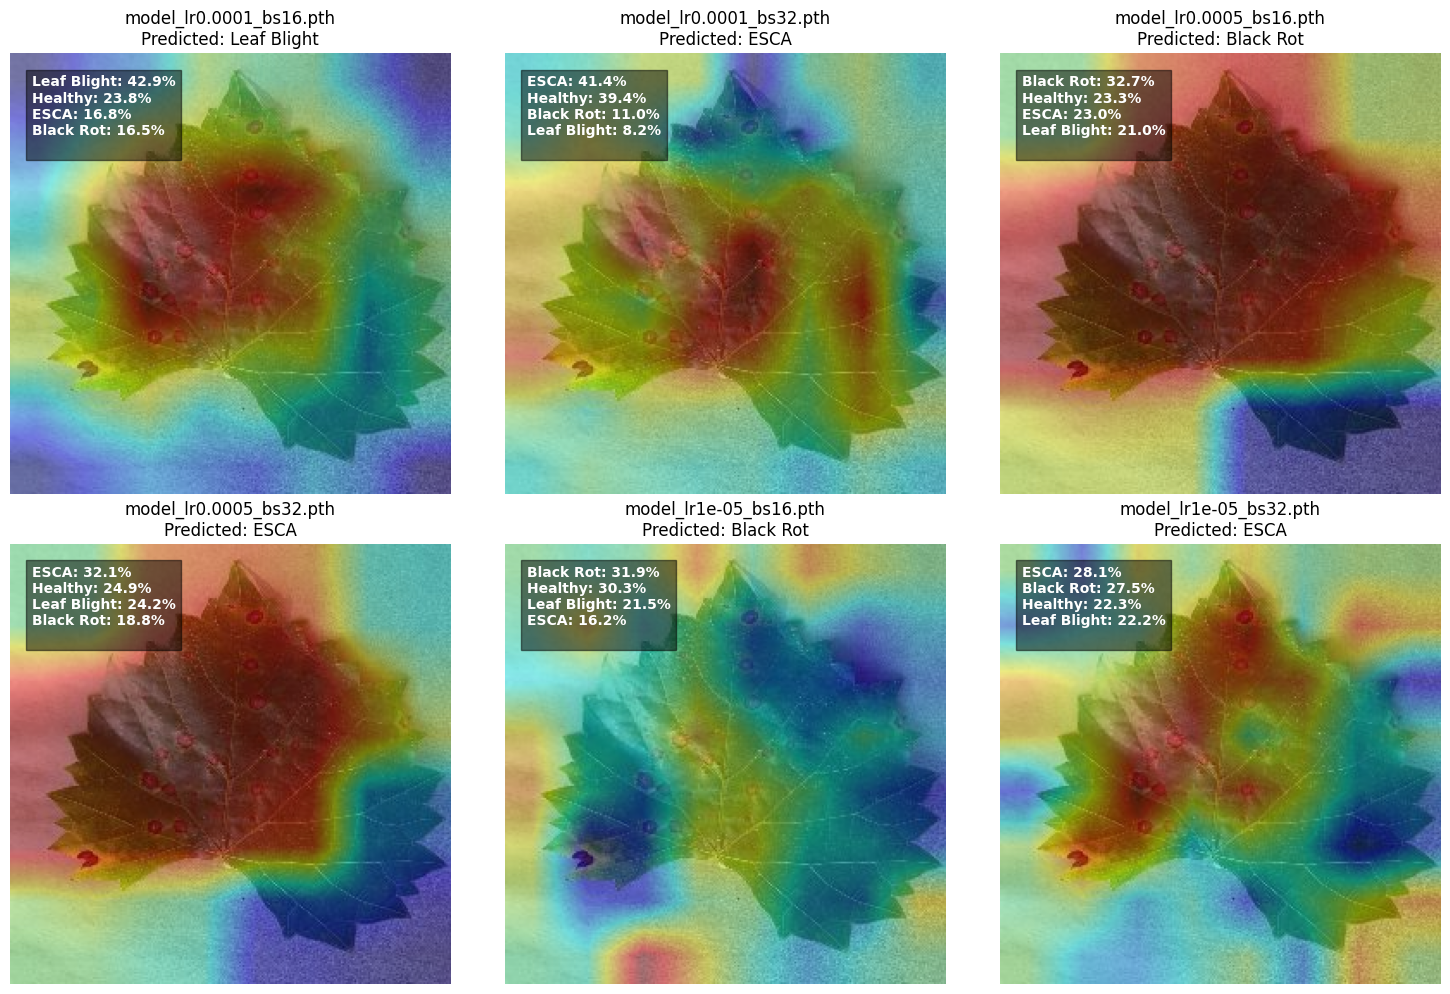

In [ ]:
import os
import glob
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from transformers import Swinv2ForImageClassification

# Define class names for the 4 possible classes
class_names = ["Healthy", "Black Rot", "Leaf Blight", "ESCA"]

# Define the model loading function
def load_model(model_path, num_classes):
    model = Swinv2ForImageClassification.from_pretrained(
        "microsoft/swinv2-base-patch4-window8-256",
        ignore_mismatched_sizes=True  # Prevents errors due to classifier mismatch
    )
    # Load the checkpoint while ignoring the classifier layer
    checkpoint = torch.load(model_path, map_location="cuda" if torch.cuda.is_available() else "cpu")
    checkpoint = {k: v for k, v in checkpoint.items() if "classifier" not in k}  # Remove classifier weights
    model.load_state_dict(checkpoint, strict=False)

    # Reinitialize classifier head with the correct number of classes
    model.classifier = torch.nn.Linear(model.config.hidden_size, num_classes)
    
    # Move model to device and set to evaluation mode
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()
    
    return model

# Grad-CAM class for SwinV2 (adapted for transformer-based architectures)
class SwinV2GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks to capture the activations and gradients
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output  # Expected shape: [Batch, Tokens, Channels]

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]  # Expected shape: [Batch, Tokens, Channels]

    def generate_cam(self, input_tensor, class_idx):
        # Forward pass
        output = self.model(input_tensor)
        logits = output.logits
        score = logits[:, class_idx]  # Target score

        # Backward pass
        self.model.zero_grad()
        score.backward(retain_graph=True)

        # Retrieve gradients and activations
        gradients = self.gradients.detach()  # [B, Tokens, Channels]
        activations = self.activations.detach()  # [B, Tokens, Channels]

        # Global Average Pooling along the token dimension (dim=1)
        weights = torch.mean(gradients, dim=1, keepdim=True)  # [B, 1, Channels]

        # Compute weighted activations, resulting in shape [B, Tokens]
        cam = torch.sum(weights * activations, dim=2)
        cam = cam[0]  # assume batch size 1; shape: [Tokens]

        # Compute the side length assuming a square layout of tokens
        num_tokens = cam.shape[0]
        side = int(np.sqrt(num_tokens))
        if side * side != num_tokens:
            raise ValueError(f"Number of tokens ({num_tokens}) is not a perfect square.")
        
        # Reshape the CAM to a 2D spatial map
        cam = cam.reshape(side, side)
        
        # Normalize the heatmap between 0 and 1
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        
        return cam.cpu().numpy()

# Define the image preprocessing transform
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load a sample image (replace the path with your dataset image)
image_path = "dataset/train/Black Rot/0a06c482-c94a-44d8-a895-be6fe17b8c06___FAM_B.Rot 5019.JPG"
image_cv = cv2.imread(image_path)
if image_cv is None:
    raise ValueError(f"Image not found at path: {image_path}")
image_cv = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)
image = Image.fromarray(image_cv)
input_tensor = transform(image).unsqueeze(0).to("cuda" if torch.cuda.is_available() else "cpu")

# Get list of model files from the hp-swinv2-base directory
model_files = sorted(glob.glob(os.path.join("hp-swinv2-base", "*.pth")))
print("Found model files:", model_files)

num_classes = 4  # Use 4 classes: Healthy, Black Rot, Leaf Blight, ESCA

# Prepare subplots (2 rows x 3 columns for six models)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Loop through each model file and compute Grad-CAM visualization
for idx, model_file in enumerate(model_files):
    # Load model
    model = load_model(model_file, num_classes)
    
    # Select target layer for Grad-CAM (adjust if needed)
    target_layer = model.swinv2.encoder.layers[-1].blocks[-1].attention.self

    grad_cam = SwinV2GradCAM(model, target_layer)
    
    # Get output logits and compute softmax probabilities
    with torch.no_grad():
        output = model(input_tensor).logits  # shape: [1, 4]
        probabilities = torch.softmax(output, dim=1)[0]  # shape: [4]
        predicted_class = output.argmax(dim=1).item()
    
    # Sort probabilities in descending order
    sorted_probs, sorted_indices = torch.sort(probabilities, descending=True)
    
    # Create annotation text with the top 4 percentages; top is bolded
    annotation_text = ""
    for i in range(4):
        class_idx = sorted_indices[i].item()
        prob = sorted_probs[i].item()
        class_label = class_names[class_idx]
        annotation_text += f"{class_label}: {prob*100:.1f}%\n"

    # Generate Grad-CAM heatmap (using the top predicted class for visualization)
    heatmap = grad_cam.generate_cam(input_tensor, predicted_class)
    
    # Convert the PIL image to NumPy array for OpenCV processing
    image_np = np.array(image)
    
    # Resize heatmap to match image dimensions
    heatmap_resized = cv2.resize(heatmap, (image_np.shape[1], image_np.shape[0]))
    
    # Convert heatmap to 8-bit and apply a color map
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    
    # Convert original image from RGB to BGR (for OpenCV blending)
    image_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
    
    # Blend the heatmap with the original image
    superimposed_img = cv2.addWeighted(image_bgr, 0.6, heatmap_color, 0.4, 0)
    
    # Convert back to RGB for display with Matplotlib
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    # Plot the result on the corresponding subplot
    ax = axes[idx]
    ax.imshow(superimposed_img_rgb)
    # Place the annotation text on the image (top-left corner in axes coordinates)
    ax.text(
        0.05, 0.95, annotation_text, transform=ax.transAxes, fontsize=10, 
        verticalalignment='top', color='white', 
        bbox=dict(facecolor='black', alpha=0.5),
        fontweight='bold'  # Apply bold formatting
    )
    ax.set_title(f"{os.path.basename(model_file)}\nPredicted: {class_names[predicted_class]}")
    ax.axis("off")

# Hide any extra subplots if there are fewer than expected
for j in range(idx + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


In [70]:
for name, module in model.named_modules():
    print(name)


swinv2
swinv2.embeddings
swinv2.embeddings.patch_embeddings
swinv2.embeddings.patch_embeddings.projection
swinv2.embeddings.norm
swinv2.embeddings.dropout
swinv2.encoder
swinv2.encoder.layers
swinv2.encoder.layers.0
swinv2.encoder.layers.0.blocks
swinv2.encoder.layers.0.blocks.0
swinv2.encoder.layers.0.blocks.0.attention
swinv2.encoder.layers.0.blocks.0.attention.self
swinv2.encoder.layers.0.blocks.0.attention.self.continuous_position_bias_mlp
swinv2.encoder.layers.0.blocks.0.attention.self.continuous_position_bias_mlp.0
swinv2.encoder.layers.0.blocks.0.attention.self.continuous_position_bias_mlp.1
swinv2.encoder.layers.0.blocks.0.attention.self.continuous_position_bias_mlp.2
swinv2.encoder.layers.0.blocks.0.attention.self.query
swinv2.encoder.layers.0.blocks.0.attention.self.key
swinv2.encoder.layers.0.blocks.0.attention.self.value
swinv2.encoder.layers.0.blocks.0.attention.self.dropout
swinv2.encoder.layers.0.blocks.0.attention.output
swinv2.encoder.layers.0.blocks.0.attention.outpu